### Importing relevant packages

In [77]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport
from pycaret.classification import *
from pycaret.utils import check_metric

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [76]:
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from sklearn.cluster import KMeans

from sklearn.metrics import roc_curve, plot_roc_curve, confusion_matrix, recall_score





### Relevant functions

In [3]:
def season(x):
    if x.month < 3 or x.month==12:
        return 'summer'
    if x.month >=3 and x.month < 6:
        return 'autumn'
    if x.month >=6 and x.month < 9:
        return 'winter'
    if x.month >=9 and x.month < 12:
        return 'spring'

### Reading data

In [4]:
df_rain_aus = pd.read_csv('./data/rain_data_aus.csv')
df_wt = pd.read_csv('./data/wind_table_01.csv')

In [5]:
df_rain_aus['date'] = pd.to_datetime(df_rain_aus['date'], format='%Y-%M-%d')

### Unifying datasets

In [6]:
df_rain_aus = pd.read_csv('./data/rain_data_aus.csv')

winds_filenames = [f'./data/wind_table_0{i}.csv' for i in range(2,9)]

df_winds = pd.read_csv('./data/wind_table_01.csv')
for wind in winds_filenames:
    df_append = pd.read_csv(wind)
    zipy = {x: y for x, y in zip(df_append.columns,df_winds.columns)}
    df_winds = df_winds.append(df_append.rename(columns=zipy))

In [7]:
df_rain_aus['date'] = pd.to_datetime(df_rain_aus['date'], format='%Y-%m-%d')
df_winds['date'] = pd.to_datetime(df_winds['date'], format='%Y-%m-%d')

In [8]:
df_merged = pd.merge(left=df_rain_aus,
                    right = df_winds,
                    on = ['location', 'date'])

In [9]:
df_merged['amountOfRain'].dropna(inplace=True) #highly correlated with target variable
df_merged.drop(columns=['modelo_vigente'], inplace=True) #whats that?

In [10]:
df_merged.drop_duplicates(inplace=True)

### Basic ECA

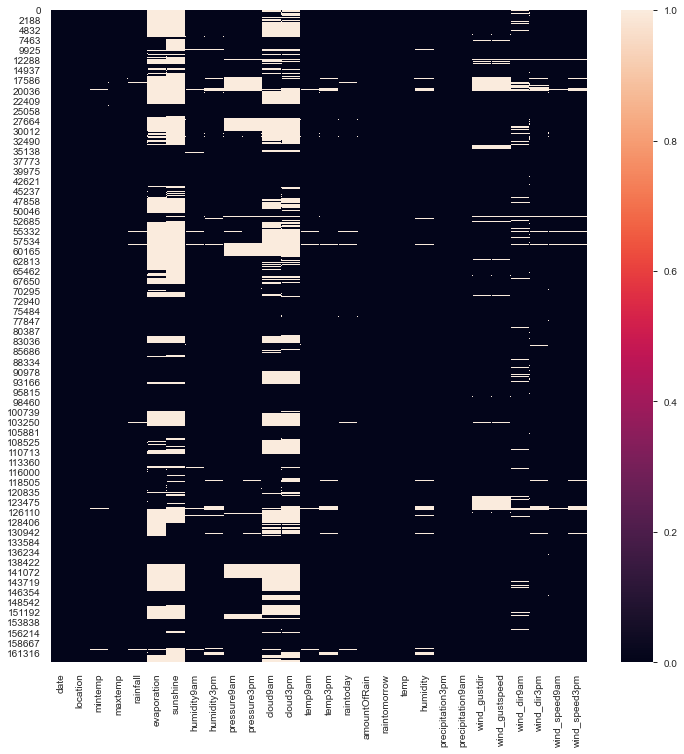

In [11]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
sns.heatmap(df_merged.isna(), ax=ax)
plt.show()

There are several features containing NaN values.
Some features seem odd, as they only contain NaN values on a fraction of the dataset and consecutively 

Specifically:
* Pressure3pm
* Pressure9am
* Windgustdir
* Windgustspeed

Code will not adress the latter two columns, as they will be eventually dropped later (due to data leakage)


In [12]:
df_merged.groupby(by='location').agg({'pressure3pm':'max', 'pressure9am':'max'}).query('pressure9am!=pressure9am')

,pressure3pm,pressure9am
location,,
MountGinini,NaN,NaN
Newcastle,NaN,NaN
Penrith,NaN,NaN
SalmonGums,NaN,NaN


In [13]:
excluded_cities = list(df_merged.groupby(by='location').agg({'pressure3pm':'max', 'pressure9am':'max'}).
                       query('pressure9am!=pressure9am').index)

For the sake of simplicity, we will not be estimating weather forecast on the above cities, as 'pressure' seemed to be a critical feature on the first sprint 


In [14]:
df_merged = df_merged[~df_merged.location.isin(excluded_cities)]

### Feature Engineering

In [15]:
#Engineering based on functions
df_merged['season'] = df_merged['date'].apply(season)
df_merged['month'] = pd.DatetimeIndex(df_merged['date']).month
df_merged['firsthalf_year'] = df_merged['month'] <=6

#Engineering based on intraday shifts
# df_merged['amp_temp'] = df_merged['mintemp'] /  df_merged['maxtemp']
df_merged['change_wind'] = (df_merged['wind_dir9am'] != df_merged['wind_dir3pm'])

df_merged['temp_delta'] = df_merged['temp3pm'] - df_merged['temp9am']
df_merged['hum_delta'] = df_merged['humidity3pm'] - df_merged['humidity9am']
df_merged['ws_delta'] = df_merged['wind_speed3pm'] - df_merged['wind_speed9am']
df_merged['cloud_delta'] = df_merged['cloud3pm'] - df_merged['cloud9am']
df_merged['pa_delta'] = df_merged['pressure3pm'] - df_merged['pressure9am']
df_merged['prec_delta'] = df_merged['precipitation3pm'] - df_merged['precipitation9am']

#Engineering based possible relevant variables on rain forecasting
df_merged['check_sunshine'] = (df_merged['sunshine'] == 0)
df_merged['high_sunshine'] = (df_merged['sunshine'] >= df_merged['sunshine'].median())
df_merged['LowHumidity3pm'] = (df_merged['humidity3pm'] <= df_merged['humidity3pm'].median())
df_merged['LowCloud3pm'] = (df_merged['cloud3pm'] <= df_merged['cloud3pm'].median())

#Engineering on target variable
df_merged['raintomorrow'] = df_merged['raintomorrow'].replace({'No': 0, 'Yes': 1})

#Dropping unnecessary columns
df_merged.drop(columns=['date', 'amountOfRain'], inplace=True)

### Variable distplots

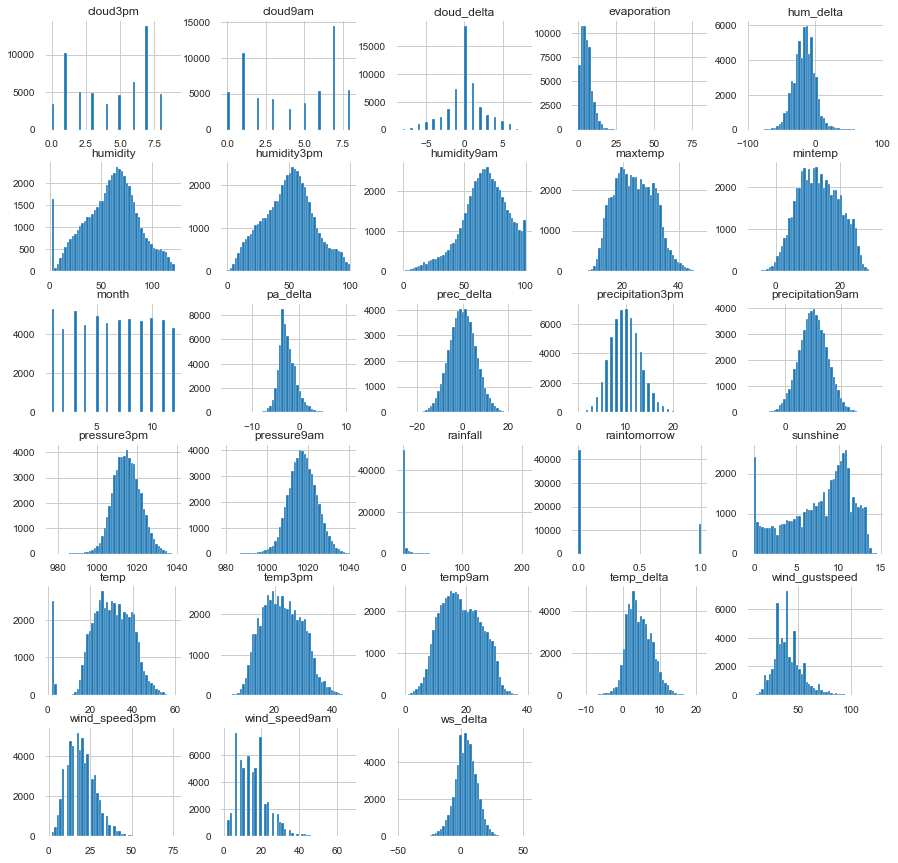

In [16]:
df_hist = df_merged.dropna().select_dtypes(exclude = ['bool','object'])
df_hist.hist(figsize = [15,15],bins = 50)
plt.show()

In [17]:
#log transformation on weird variables
# df_merged['rainfall'] = df_merged['rainfall'].apply(lambda x: np.log(x) if x>0 else x)
df_merged['evaporation'] = df_merged['evaporation'].apply(lambda x: np.log(x) if x>0 else x)
df_merged['sunshine'] = df_merged['sunshine'].apply(lambda x: np.log(x) if x>0 else x)
df_merged['temp'] = df_merged['temp'].apply(lambda x: np.log(x) if x>0 else x)

In [18]:
log_features = ['evaporation', 'sunshine', 'temp'] #'rainfall'
for i in log_features:
    df_merged[[i]] = QuantileTransformer(n_quantiles=100,
                                  output_distribution='normal',
                                  subsample=len(df_merged)).fit_transform(df_merged[[i]])

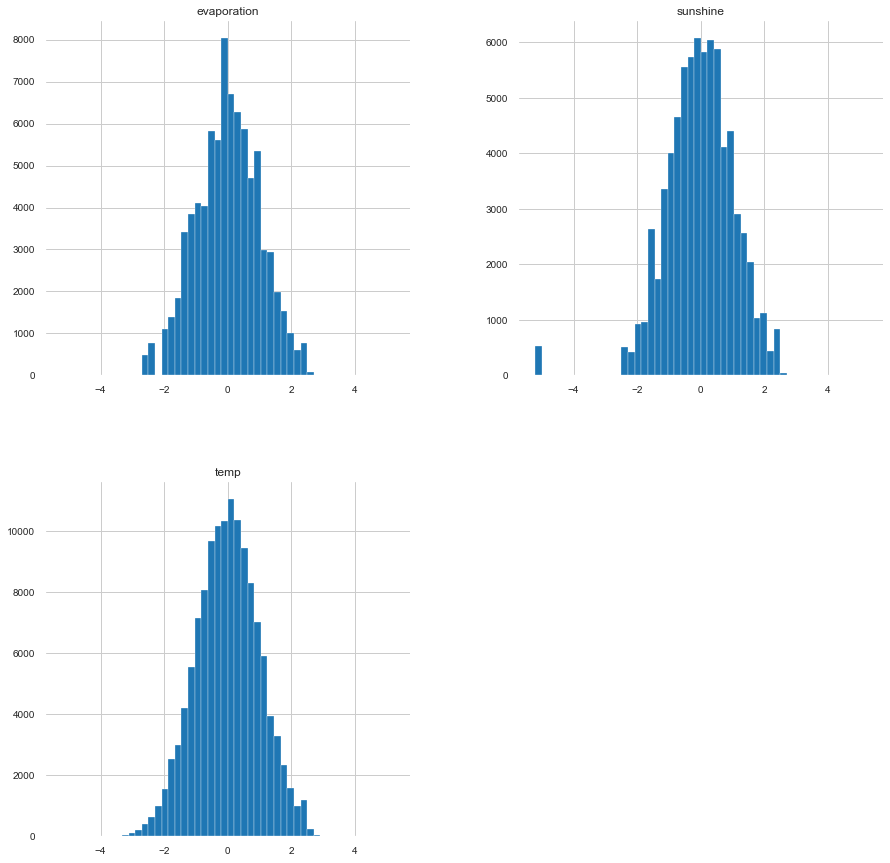

In [19]:
df_hist = df_merged[log_features]
df_hist.hist(figsize = [15,15],bins = 50)
plt.show()

In [20]:
df_merged['transformed_sunshine'] = (df_merged['sunshine'] > -4) 

### Is every city created equal?

In [21]:
# pip install opencage

In [22]:
from opencage.geocoder import OpenCageGeocode

In [23]:
df_unique_cities = pd.DataFrame(df_merged['location'].unique(), columns=['City'])

In [24]:
import re

In [25]:
df_unique_cities['City'] = df_unique_cities['City'].str.replace( r"([A-Z])", r" \1").str.strip()

In [26]:
key = 'e015b4996cb841f382533a1575b09b07'  # get api key from:  https://opencagedata.com

geocoder = OpenCageGeocode(key)
list_lat, list_long, state = [], [], []

for index, row in df_unique_cities.iterrows():
    City = row['City']    
    query = str(City)+', '+'Australia'

    results = geocoder.geocode(query)   
    lat = results[0]['geometry']['lat']
    long = results[0]['geometry']['lng']
    try:
        st = results[0]['components']['state']
    except:
        st = results[0]['components']['territory']
    
    list_lat.append(lat)
    list_long.append(long)    
    state.append(st)


df_unique_cities['lat'] = list_lat   
df_unique_cities['lon'] = list_long
df_unique_cities['state'] = state



In [27]:
df_unique_cities = pd.concat([df_unique_cities,
                               pd.DataFrame(df_merged['location'].unique(), columns=['location'])], 
                             axis=1)


In [28]:
df_final = pd.merge(left=df_merged,
                    right = df_unique_cities,
                    on = ['location'])

In [29]:
df_kmeans = df_final.groupby(by='location').agg({'lat':'max', 'lon':'max'})

In [30]:
kmeans = KMeans(n_clusters=11)
kmeans.fit(df_kmeans[['lat', 'lon']])

KMeans(n_clusters=11)

In [31]:
df_kmeans['kmeans_label'] = kmeans.labels_

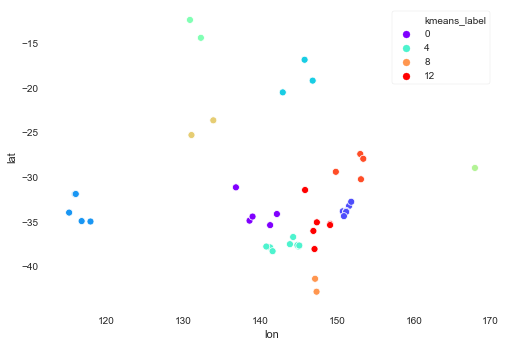

In [32]:
sns.scatterplot(x='lon', y='lat', hue='kmeans_label', data=df_kmeans, palette='rainbow')

In [33]:
df_kmeans.drop(columns=['lat', 'lon'], inplace=True)
df_final = pd.merge(left=df_final,
                    right = df_kmeans,
                    on = ['location'])

In [34]:
df_final.to_csv('./data-generated/to_tableau.csv')

In [35]:
#Dropping geo columns that are irrelevant for machine learning
df_final.drop(columns=['location','lat','lon','City', 'state'], inplace=True)
#Dropping columns that would not be available at 5pm
df_merged.drop(columns=['maxtemp','mintemp', 'rainfall', 'wind_gustdir','wind_gustspeed'], inplace=True)


### It is time for PyCarat!

In [36]:
data = df_final.sample(frac=0.95, random_state=42)
data_unseen = df_final.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (123891, 41)
Unseen Data For Predictions: (6521, 41)


In [37]:
py_carat = setup(data = data, 
                 target = 'raintomorrow', 
                 session_id=42,
                 silent=True,
                 verbose=False,
                 numeric_imputation='median',
                 ignore_low_variance=True,
                 normalize=True,
                 remove_multicollinearity=True,
                 n_jobs=-1,
                 feature_selection_threshold=.5,
                 feature_selection=True,
                numeric_features = ['evaporation',
                                    'sunshine',
                                    'humidity9am',
                                    'humidity3pm',
                                    'pressure9am',
                                    'pressure3pm',
                                    'cloud9am',
                                    'cloud3pm',
                                    'temp9am',
                                    'temp3pm',
                                    'temp',
                                    'humidity',
                                    'precipitation3pm',
                                    'precipitation9am',
                                    'wind_speed9am',
                                    'wind_speed3pm',
                                    'temp_delta',
                                    'hum_delta',
                                    'ws_delta',
                                    'cloud_delta',
                                    'pa_delta',
                                    'prec_delta'],
                categorical_features = ['kmeans_label',
                                        'raintoday',
                                        'wind_dir9am',
                                        'wind_dir3pm',
                                        'season',
                                        'month',
                                        'firsthalf_year',
                                        'change_wind',
                                        'check_sunshine',
                                        'high_sunshine',
                                        'LowHumidity3pm',
                                        'LowCloud3pm',
                                        'transformed_sunshine',
                                        'check_sunshine',
                                        'high_sunshine',
                                        'LowHumidity3pm',
                                        'LowCloud3pm',
                                        'transformed_sunshine']
                )

In [38]:
best_model = compare_models(fold=3, turbo=True, exclude=['knn', 'catboost', 'et', 'gbc'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Light Gradient Boosting Machine,0.8597,0.8931,0.5605,0.7519,0.6422,0.5572,0.5666,1.8556
1,Extreme Gradient Boosting,0.8590,0.8927,0.5700,0.7429,0.6450,0.5590,0.5666,16.0030
2,Logistic Regression,0.8488,0.8765,0.5234,0.7273,0.6087,0.5181,0.5289,1.2140
3,Linear Discriminant Analysis,0.8474,0.8744,0.5292,0.7178,0.6092,0.5171,0.5264,1.4613
4,Ridge Classifier,0.8464,0.0000,0.4672,0.7564,0.5776,0.4901,0.5113,0.2981
5,SVM - Linear Kernel,0.8452,0.0000,0.4855,0.7414,0.5832,0.4937,0.5122,0.9805
6,Ada Boost Classifier,0.8451,0.8708,0.5077,0.7206,0.5957,0.5034,0.5153,10.9500
7,Random Forest Classifier,0.8429,0.8492,0.4592,0.7440,0.5678,0.4784,0.4992,1.9180
8,Decision Tree Classifier,0.7873,0.7014,0.5454,0.5258,0.5354,0.3976,0.3977,3.0148
9,Naive Bayes,0.7454,0.8044,0.6971,0.4565,0.5517,0.3846,0.4014,0.1949


In [39]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8658,0.8970,0.5752,0.7694,0.6583,0.5769,0.5864
1,0.8599,0.8939,0.5449,0.7640,0.6361,0.5524,0.5645
2,0.8600,0.8962,0.5726,0.7455,0.6477,0.5622,0.5699
3,0.8539,0.8918,0.5741,0.7192,0.6385,0.5484,0.5539
4,0.8595,0.8964,0.5757,0.7416,0.6482,0.5622,0.5692
5,0.8584,0.8902,0.5444,0.7573,0.6334,0.5486,0.5601
6,0.8582,0.8914,0.5511,0.7516,0.6359,0.5504,0.5606
7,0.8598,0.8970,0.5498,0.7596,0.6379,0.5537,0.5648
8,0.8572,0.8922,0.5554,0.7442,0.6361,0.5496,0.5587
9,0.8658,0.8996,0.5621,0.7788,0.6530,0.5724,0.5841


In [40]:
tuned_lgbm = tune_model(lgbm, n_iter=50,optimize='Recall') 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8639,0.8983,0.6018,0.7438,0.6653,0.5811,0.5863
1,0.8578,0.8933,0.5623,0.7425,0.6400,0.5535,0.5618
2,0.8611,0.8969,0.5983,0.7343,0.6593,0.5732,0.5779
3,0.8601,0.8953,0.6085,0.7249,0.6616,0.5743,0.5778
4,0.8643,0.8996,0.5993,0.7468,0.6650,0.5811,0.5867
5,0.8589,0.8921,0.5634,0.7464,0.6421,0.5563,0.5649
6,0.8589,0.8921,0.5757,0.7386,0.6471,0.5605,0.5673
7,0.8576,0.8960,0.5760,0.7329,0.6450,0.5575,0.5639
8,0.8584,0.8919,0.5806,0.7335,0.6481,0.5610,0.5670
9,0.8647,0.8982,0.5770,0.7631,0.6571,0.5749,0.5836


In [41]:
evaluate_model(tuned_lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

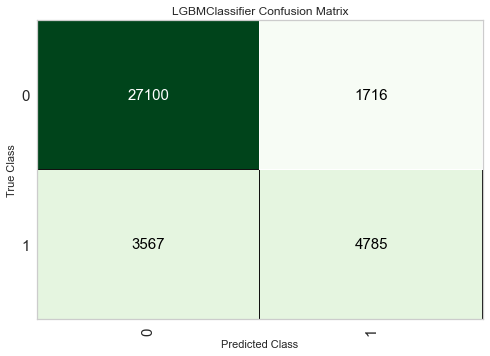

In [42]:
plot_model(tuned_lgbm, plot='confusion_matrix')

In [43]:
get_prob = optimize_threshold(tuned_lgbm, 
                   true_negative = 2, 
                   false_negative = -3,
                   true_positive = 3,
                   false_positive = 0
                  )

Optimized Probability Threshold: 0.22 | Optimized Cost Function: 61806


In [51]:
predict_model(tuned_lgbm,probability_threshold = .22);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8221,0.8917,0.7707,0.5782,0.6607,0.5435,0.5538


In [52]:
finalized_gbm = finalize_model(tuned_lgbm)

In [53]:
get_prob = optimize_threshold(finalized_gbm, 
                   true_negative = 2, 
                   false_negative = -3,
                   true_positive = 3,
                   false_positive = 0
                  )

Optimized Probability Threshold: 0.32 | Optimized Cost Function: 76142


In [54]:
predict_model(finalized_gbm, probability_threshold = .32);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9445,0.987,0.9276,0.8416,0.8825,0.8463,0.848


In [55]:
'''
Quite obvious to reach enhanced resuts - model had already seen the 'test' dataset
We will now test the finalized model on unseen data
'''

"\nQuite obvious to reach enhanced resuts - model had already seen the 'test' dataset\nWe will now test the finalized model on unseen data\n"

In [73]:
unseen_predictions = predict_model(finalized_gbm, data=data_unseen, probability_threshold = .22)

In [78]:
metrics_list = ['Accuracy', 'AUC', 'Recall','Precision',  'F1']
metrics_figures = []

for metric in metrics_list:
    metrics_figures.append(check_metric(unseen_predictions['raintomorrow'], 
             unseen_predictions['Label'].astype(int),
             metric=metric))
    
pd.DataFrame(data=zip(metrics_figures), index = metrics_list, columns=['Finalized Light GBM model']).T

,Accuracy,AUC,Recall,Precision,F1
Finalized Light GBM model,0.8244,0.8157,0.8001,0.5691,0.6651
